In [1]:
!pip install -q openpyxl
!pip install -q datasets
!pip install -q conllu

In [2]:
import random

In [3]:
from datasets import load_dataset

data = load_dataset("universal_dependencies", "ar_padt")


Found cached dataset universal_dependencies (/home/magedsaeed/.cache/huggingface/datasets/universal_dependencies/ar_padt/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 6075
    })
    validation: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 909
    })
    test: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 680
    })
})

In [5]:
TAGS = [
    "NOUN",
    "PUNCT",
    "ADP",
    "NUM",
    "SYM",
    "SCONJ",
    "ADJ",
    "PART",
    "DET",
    "CCONJ",
    "PROPN",
    "PRON",
    "X",
    "_",  # we need to drop this class is it is meant to refer to unsplit words. For instance, the word وكانت is split into و and كانت but it is assigned this class as a whole.
    "ADV",
    "INTJ",
    "VERB",
    "AUX",
]
tag_names_to_labels = {tag_name: tag_label for tag_label, tag_name in enumerate(TAGS)}
tag_labels_to_names = {
    tag_label: tag_name for tag_name, tag_label in tag_names_to_labels.items()
}


In [6]:
# prompt without fewshots
sys_msg = """
I wish you can generate a table of Arabic POS tags following Universal Dependencies tagset in the following format:
TOKEN  :  POS
Please note that I tokenized the sentence for you. Please do not change, add, combine, merge or remove any of these tokens such as ب and ه. Please consider punctuation marks as separate tokens, always. Split them as two separate tokens if they come together and classify each of them independently.
Please give me the generated table and that is it. No further discussion, explanation or extrapolation required.
""".strip()


# prompt with fewshots
# sys_msg_with_fewshots = lambda fewshots: """
# I wish you can generate a table of Arabic POS tags following Universal Dependencies tagset in the following format:
# WORD  |  POS
# Please do not forget to split punctuation marks such as quotes and classify them.
# Please, also, do not forget to split words that have CCONJ tokens such as و and ف.
# Please give me the generated table and that is it. No further discussion, explanation or extrapolation required.
# here are some examples to consider:
# """+'\n'.join(f"""
# sentence: {sentence}
# tags:
# {tags}""" for (sentence,tags) in fewshots)+"""

# Now, My sentence is:
# {input_sentence}
# """


In [7]:
def construct_tags_map_str(sentence_tokens, tags):
    assert len(sentence_tokens)==len(tags), "lengths of the tokens and its tags does not match!"
    tags_map = ""
    for word, tag_label in zip(sentence_tokens, tags):
        if tag_label == 13:  # see why in the comment in TAGS list
            continue
        tags_map += f"{word}:{tag_labels_to_names[tag_label]}"
        tags_map += "\n"
    return tags_map


In [8]:
# testing fewshots prompt
# sentences = [
#     'السلام عليكم ورحمة الله',
#     'كيف الحال'
# ]
# fewshots = [(
#     sentence,
#     construct_tags_map_str(sentence,[random.choice(range(len(TAGS))) for _ in sentence.split()])
# )for sentence in sentences]
# print(sys_msg_with_fewshots(fewshots).format(input_sentence="وكانت خسائر المجموعة الاسبانية الرسمية تراكمت في السنوات العشر الاخيرة لتبلغ 920 مليون يورو"))


In [9]:
def create_chat_prompt(input_text):
    return [
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": input_text},
    ]


def create_chat_example(sentence, tags):
    return [
        {"role": "system", "content": sentence, "name": "example_user"},
        {"role": "system", "content": tags, "name": "example_assistant"},
    ]


In [10]:
!mkdir -p ../registry/data/pos_tagging

In [11]:
small_samples_data = data["train"].filter(lambda example: len(example['tokens']) < 100)
small_samples_data

Loading cached processed dataset at /home/magedsaeed/.cache/huggingface/datasets/universal_dependencies/ar_padt/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7/cache-c7383425e2cd321a.arrow


Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 5774
})

In [12]:
small_samples_data = data['train'].to_pandas()
small_samples_data = small_samples_data.loc[small_samples_data['tokens'].map(len) < 50]
small_samples_data

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc
0,afp.20000715.0075:p1u1,برلين ترفض حصول شركة اميركية على رخصة تصنيع دب...,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[بَرلِين, رَفَض, حُصُول, شَرِكَة, أَمِيرِكِيّ,...","[12, 16, 0, 0, 6, 2, 0, 0, 0, 1, 12, 1, 6]","[X---------, VIIA-3FS--, N------S4R, N------S2...","[{'Foreign': 'Yes'}, {'Aspect': 'Imp', 'Gender...","[2, 0, 2, 3, 4, 7, 3, 7, 8, 11, 9, 11, 9]","[nsubj, root, obj, nmod, amod, case, obl:arg, ...","[[('nsubj', 2)], [('root', 0)], [('obj', 2)], ...","[{'Vform': 'بَرلِين', 'Gloss': 'Berlin', 'Root..."
2,afp.20000715.0075:p3u1,وفي نيسان/ابريل الماضي، تخلت الدولة الاسبانية ...,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[_, وَ, فِي, نِيسَان, /, أَبرِيل, مَاضِي, ،, ت...","[13, 9, 2, 0, 1, 0, 6, 1, 16, 0, 6, 2, 0, 1, 1...","[None, C---------, P---------, N------S2I, G--...","[None, None, {'AdpType': 'Prep'}, {'Case': 'Ge...","[None, 0, 3, 8, 5, 3, 3, 6, 1, 8, 9, 12, 8, 15...","[_, root, case, obl, punct, appos, amod, punct...","[None, [('root', 0)], [('case', 3)], [('obl:فِ...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
3,afp.20000715.0075:p4u1,وكانت خسائر المجموعة الاسبانية الرسمية تراكمت ...,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[_, وَ, كَان, خَسَارَة, مَجمُوعَة, إِسبَانِيّ,...","[13, 9, 16, 0, 0, 6, 6, 16, 2, 0, 3, 6, 13, 9,...","[None, C---------, VP-A-3FS--, N------P1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 4, 3, 2, 9, 7, 9, 9, None, ...","[_, root, parataxis, nsubj, nmod, amod, amod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
4,afp.20000715.0075:p5u1,واشارت صحيفة الاحد الى ان المستشار شرودر يعتبر...,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[_, وَ, أَشَار, صَحِيفَة, أَحَد, إِلَى, أَنَّ,...","[13, 9, 16, 0, 0, 2, 5, 0, 12, 16, 5, 0, 0, 6,...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 9, 9, 9, 7, 2, 19, 19, 11, ...","[_, root, parataxis, nsubj, nmod, mark, mark, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
5,afp.20000715.0075:p6u1,وتعذر لمتحدثة باسم وزارة الدفاع الالمانية ان ت...,"[وتعذر, و, تعذر, لمتحدثة, ل, متحدثة, باسم, ب, ...","[_, وَ, تَعَذَّر, _, لِ, مُتَحَدِّثَة, _, بِ, ...","[13, 9, 16, 13, 2, 0, 13, 2, 0, 0, 0, 6, 5, 16...","[None, C---------, VP-A-3MS--, None, P--------...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, None, 4, 2, None, 7, 5, 4, 7, 7, ...","[_, root, parataxis, _, case, obl:arg, _, case...","[None, [('root', 0)], [('parataxis', 1)], None...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
...,...,...,...,...,...,...,...,...,...,...,...
6068,xinhua.20030511.0192:p1u1,تنسيق المواقف بين مصر وفلسطين قبيل زيارة باول ...,"[تنسيق, المواقف, بين, مصر, وفلسطين, و, فلسطين,...","[تَنسِيق, مَوقِف, بَينَ, مصر, _, وَ, فِلَسطِين...","[0, 0, 2, 12, 13, 9, 0, 2, 0, 12, 2, 0]","[N------S1R, N------P2D, PI------4-, U--------...","[{'Case': 'Nom', 'Definite': 'Cons', 'Number':...","[0, 1, 4, 1, None, 6, 4, 8, 1, 8, 11, 8]","[root, nmod, case, obl:arg, _, cc, conj, case,...","[[('root', 0)], [('nmod:gen', 1)], [('case', 4...","[{'Vform': 'تَنسِيقُ', 'Gloss': 'coordination,..."
6069,xinhua.20030511.0192:p2u1,القاهرة 11 مايو,"[القاهرة, 11, مايو]","[قَاهِرَة, 11, مَايُو]","[0, 3, 0]","[N------S1D, Q---------, N------S2I]","[{'Case': 'Nom', 'Definite': 'Def', 'Number': ...","[0, 1, 2]","[root, dep, nmod]","[[('root', 0)], [('dep', 1)], [('nmod:gen', 2)]]","[{'Vform': 'اَلقَاهِرَةُ', 'Gloss': 'Cairo', '..."
6072,xinhua.20030511.0192:p5u1,واكد شعث فى الاتصال على ضرورة قبول الجانب الإس...,"[واكد, و, أكد, شعث, فى, الاتصال, على, ضرورة, ق...","[_, وَ, أَكَّد, شعث, فِي, اِتِّصَال, عَلَى, ضَ...","[13, 9, 16, 12, 2, 0, 2, 0, 0, 0, 6, 0, 12, 0,...","[None, C---------, VP-A-3MS--, U---------, P--...","[None, None, {'Aspect': 'Perf', 'Gende

In [13]:
dev_df = small_samples_data
dev_df["sample"] = dev_df.apply(
    lambda x: create_chat_example(
        sentence=' '.join([token for token,tag in zip(x["tokens"],x["upos"]) if tag != 13]),
        tags=construct_tags_map_str(sentence_tokens=x["tokens"], tags=x["upos"]),
    ),
    axis=1,
)
dev_df[["sample"]].to_json(
    "../registry/data/pos_tagging/pos_tagging_fewshots.jsonl",
    lines=True,
    orient="records",
    force_ascii=False,
)

test_df = data["test"].to_pandas()

test_df["input"] = test_df.apply(
    lambda row: create_chat_prompt(
        input_text=' '.join([token for token,tag in zip(row["tokens"],row["upos"]) if tag != 13])
    ),
    axis=1,
)
test_df["ideal"] = test_df.apply(
    lambda row: construct_tags_map_str(
        sentence_tokens=row["tokens"],
        tags=row["upos"],
    ),
    axis=1,
)
test_df[["input", "ideal"]].to_json(
    "../registry/data/pos_tagging/pos_tagging_samples.jsonl",
    lines=True,
    orient="records",
    force_ascii=False,
)


In [14]:
import os

os.environ["OPENAI_API_KEY"] = "<openai-key>"
os.environ["EVALS_THREADS"] = "1"
os.environ["EVALS_THREAD_TIMEOUT"] = "600"


In [15]:
!ls

ajgt.ipynb  easc.ipynb	  tashkeela.ipynb		    un_v1.ipynb
apb.ipynb   metrec.ipynb  universal_dependencies_POS.ipynb


In [16]:
!ls ../registry/data/pos_tagging

pos_tagging_fewshots.jsonl  pos_tagging_samples.jsonl


In [17]:
pos_tagging_task_specs = """
pos_tagging:
    id: pos_tagging.test.v1
    metrics: [accuracy]
    description: Evaluate Arabic POS tagging
# Define the eval
pos_tagging.test.v1:
  # Specify the class name as a dotted path to the module and class
  class: evals.elsuite.pos_tagging:POSTagger
  args:
    samples_jsonl: pos_tagging/pos_tagging_samples.jsonl
    few_shot_jsonl: pos_tagging/pos_tagging_fewshots.jsonl # path to few shots file
    num_few_shot: 3 # max few shots to use

""".strip()
with open("../registry/evals/pos_tagging.yaml", "w") as file:
    file.write(pos_tagging_task_specs)


In [18]:
!oaieval gpt-3.5-turbo pos_tagging --max_samples 10

[2023-05-02 06:02:15,908] [registry.py:156] Loading registry from /home/magedsaeed/MyProjects/evals/evals/registry/evals
[2023-05-02 06:02:16,000] [registry.py:156] Loading registry from /home/magedsaeed/.evals/evals
[2023-05-02 06:02:16,989] [oaieval.py:213] Run started: 230502030216D3S3QLNR
[2023-05-02 06:02:16,992] [data.py:75] Fetching pos_tagging/pos_tagging_fewshots.jsonl
[2023-05-02 06:02:17,034] [data.py:75] Fetching pos_tagging/pos_tagging_samples.jsonl
[2023-05-02 06:02:17,044] [eval.py:32] Evaluating 10 samples
[2023-05-02 06:02:17,047] [eval.py:152] Running in threaded mode with 1 threads!
 30%|█████████████▏                              | 3/10 [00:21<00:56,  8.14s/it][2023-05-02 06:02:39,484] [_common.py:105] Backing off openai_chat_completion_create_retrying(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-gRO0WJ3ChMWZJMHenTPTkMJR on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through ou

In [19]:
!ls /tmp/evallogs

230502030047E6SAQHSG_gpt-3.5-turbo_pos_tagging.jsonl
230502030216D3S3QLNR_gpt-3.5-turbo_pos_tagging.jsonl


In [20]:
import pandas as pd

events = f"/tmp/evallogs/230502030216D3S3QLNR_gpt-3.5-turbo_pos_tagging.jsonl"

with open(events, "r") as f:
    events_df = pd.read_json(f, lines=True)


In [21]:
events_df[events_df["final_report"].notnull()]["final_report"]


1    {'accuracy': 0.820178351748011}
Name: final_report, dtype: object

<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

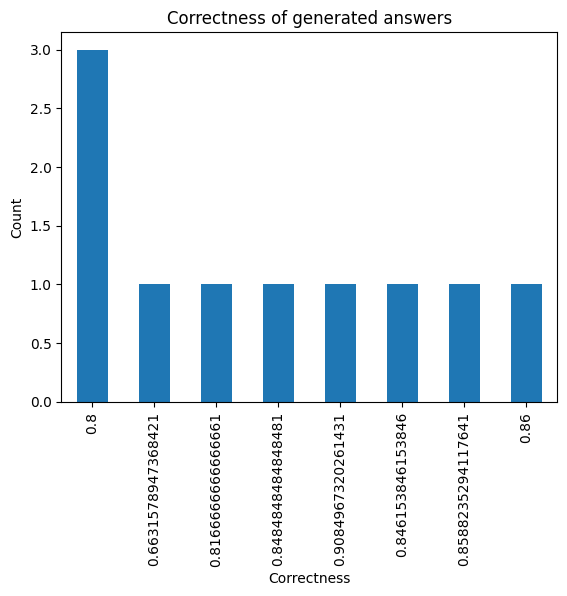

In [22]:
matches_df = events_df[events_df.type == "tagging"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.accuracy.value_counts().plot.bar(
    title="Correctness of generated answers", xlabel="Correctness", ylabel="Count"
)


In [23]:
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt[-1]}")
    print(f"Sampled: {r.sampled}")
    print(f"{i}", "--" * 25)


Prompt: {'role': 'user', 'content': 'اعلنت الحكومة الامريكية خططا جديدة يوم الاربعاء ل صرف اكثر من ثلاثة الاف من العاملين على اجهزة الفحص فى المطارات من اجل توفير اموال .'}
Sampled: اعلنت:VERB
الحكومة:NOUN
الامريكية:ADJ
خططا:NOUN
جديدة:ADJ
يوم:NOUN
الاربعاء:NOUN
ل:ADP
صرف:VERB
اكثر:ADV
من:ADP
ثلاثة:NUM
الاف:NOUN
من:ADP
العاملين:NOUN
على:ADP
اجهزة:NOUN
الفحص:NOUN
فى:ADP
المطارات:NOUN
من:ADP
اجل:PART
توفير:VERB
اموال:NOUN
.:PUNCT
0 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'و ترافقت هذه المعلومات مع توجيه صحيفة " الزحف الأخضر " الناطقة ب لسان حركة اللجان الثورية ، التي تعد العمود الفقري ل النظام الجماهيري المعمول ب ه في ليبيا منذ عام 1977 ، دعوة غير مسبوقة إلى إجراء إصلاحات في الأجهزة الأمنية الليبية و إلى إعادة بناء ها .'}
Sampled: و:CCONJ
ترافقت:VERB
هذه:DET
المعلومات:NOUN
مع:ADP
توجيه:NOUN
صحيفة:NOUN
":PUNCT
الزحف:NOUN
الأخضر:ADJ
":PUNCT
الناطقة:ADJ
ب:ADP
لسان:NOUN
حركة:NOUN
اللجان:NOUN
الثورية:ADJ
،:PUNCT
التي:PRON
تعد:VERB
العمود:NOUN
الف